In [1]:
using CairoMakie
using AbstractFFTs
using FourierFlows
using JLD2
using Printf
include("../analysis/Notebooks/AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [2]:
run_idx = 4
data_directory = "/scratch/nad9961/swqg/57615490/"
run_directory = data_directory * string(run_idx)

"/scratch/nad9961/swqg/57615490/4"

In [4]:
function smart_interpolation(t, field1, field2, t1, t2, u1, u2, v1, v2, grid)
    dt = t - t1
    xs =   grid.x .+ 0*grid.y'
    ys = 0*grid.x .+   grid.y'
    new_xs = xs + u1 * dt
    new_ys = ys + v1 * dt
    new_field = zeros(size(field1))
    x_idx = @. floor(Int, mod(new_xs - grid.x[1], grid.Lx) / grid.Lx * grid.nx + 1)
    y_idx = @. floor(Int, mod(new_ys - grid.y[1], grid.Ly) / grid.Ly * grid.ny + 1)
    @views new_field[x_idx, y_idx] .+= field1
    return new_field
end

function dumb_interpolation(t, field1, field2, t1, t2)
    α = (t - t1)/(t2 - t1)
    return (1 - α) * field1 + α * field2
end

dumb_interpolation (generic function with 1 method)

In [7]:
dt = (t1+t2)/2 - t1
xs =   grid.x .+ 0*grid.y'
ys = 0*grid.x .+   grid.y'

new_xs = xs + u1 * dt

x_idx = @. floor(Int, mod(new_xs - grid.x[1], grid.Lx) / grid.Lx * grid.nx + 1)

512×512 Matrix{Int64}:
 509    2    7  11  16  21  26  32  37  …  478  482  487  492  496  500  504
 509    2    8  13  17  22  28  33  39     477  481  485  490  495  500  504
 510    2    8  14  19  24  29  35  40     475  480  485  489  494  500  505
 510    3    8  14  20  26  31  36  42     474  479  484  489  494  499  505
 510    4    9  15  21  27  33  39  44     473  477  483  488  493  499  504
 510    4   10  16  22  29  35  41  47  …  471  476  481  487  492  498  504
 510    4   11  17  23  30  37  43  49     469  474  479  485  491  497  504
 510    5   11  18  25  32  39  45  52     466  472  477  484  490  497  503
 510    5   12  19  26  34  41  48  55     463  469  475  482  489  496  503
 510    5   13  20  28  36  43  51  58     460  467  473  480  488  495  502
 509    5   13  21  30  38  46  54  62  …  457  464  471  478  486  494  502
 509    5   14  22  31  40  49  58  66     454  461  469  476  484  492  501
 508    5   14  24  33  43  52  61  70     450  458  

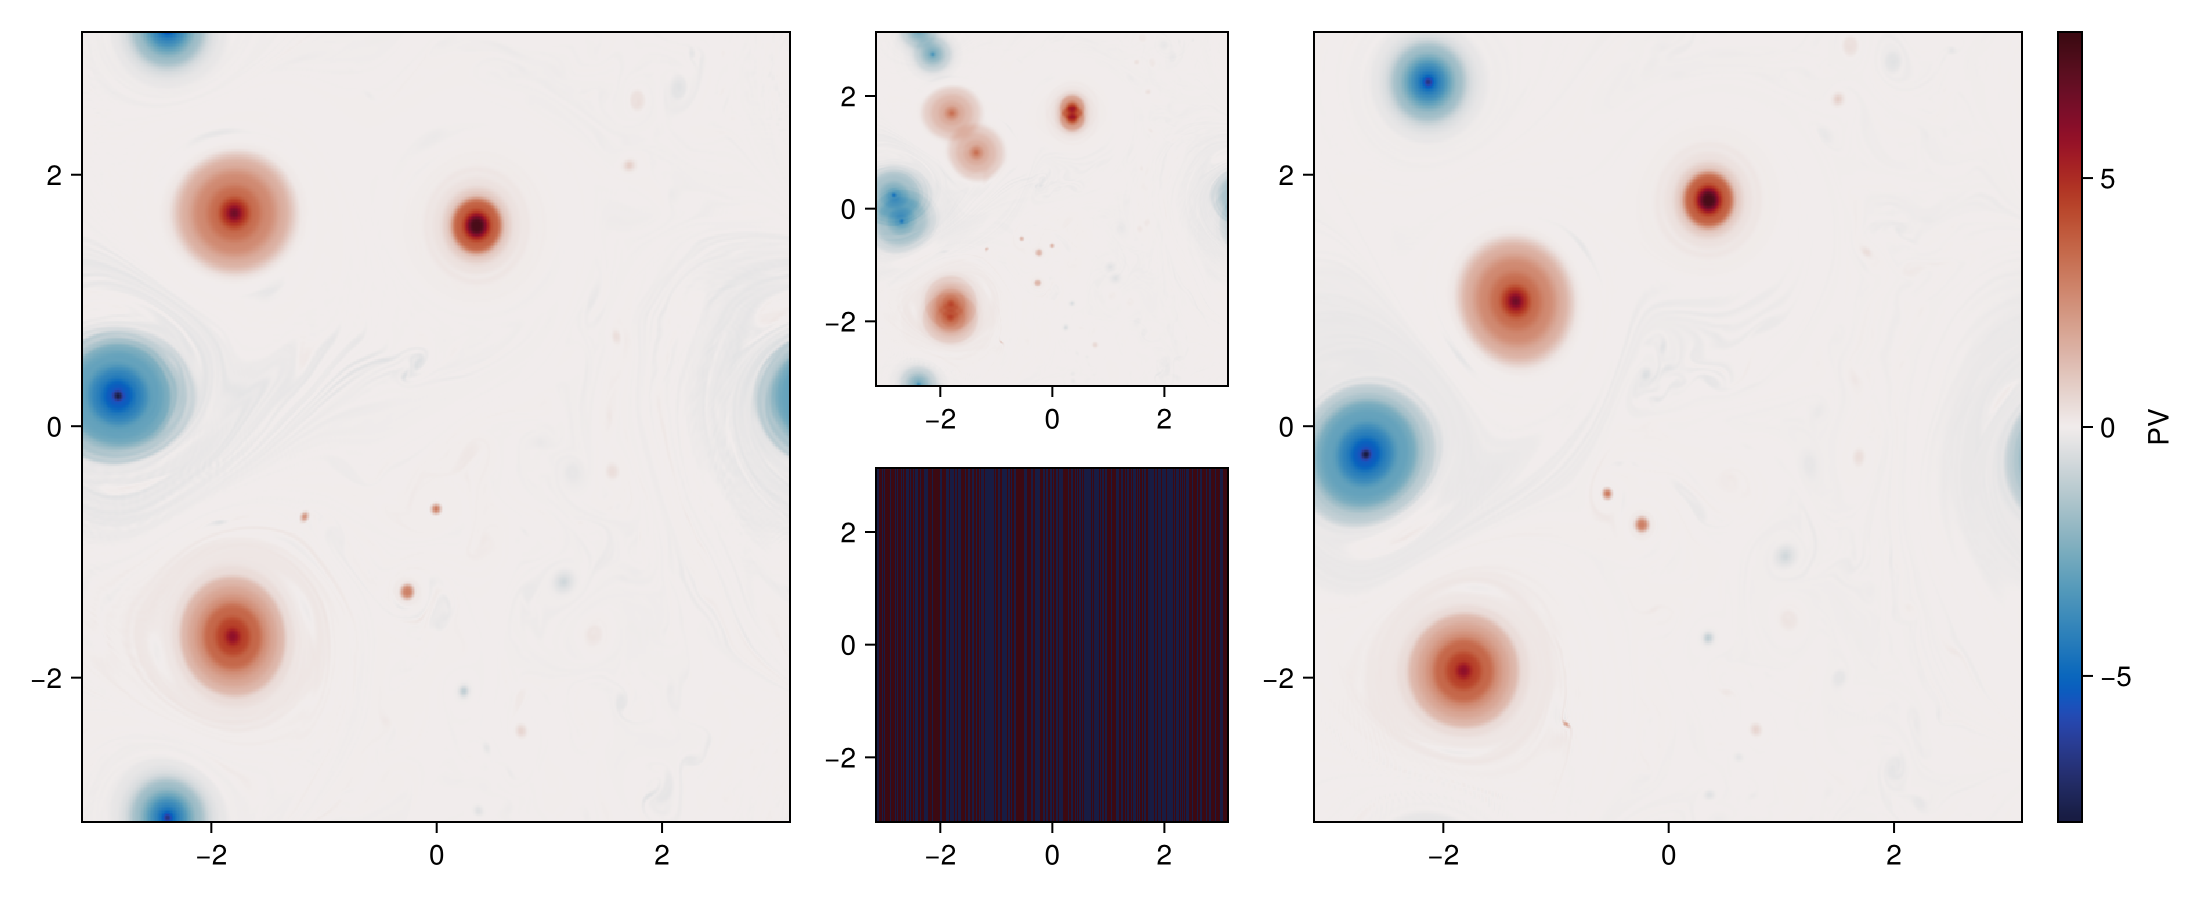

In [9]:
grid = TwoDGrid(Lx = 2π, nx = 512)
Nqgsnapshots = count_qgsw_snapshots(run_directory)
t1, q1, ψ1, u1, v1, Kd2 = load_qgsw_snapshot(run_directory, grid, 100)
t2, q2, ψ2, u2, v2, Kd2 = load_qgsw_snapshot(run_directory, grid, 110)

q_max = max(maximum(abs.(q1)), maximum(abs.(q2)))

dumb_q  = dumb_interpolation((t1+t2)/2, q1, q2, t1, t2)
smart_q = smart_interpolation((t1+t2)/2, q1, q2, t1, t2, u1, u2, v1, v2, grid)


fig = Figure()
ax1 = Axis(fig[1:2, 1])
ax2 = Axis(fig[1:2, 3])
axd = Axis(fig[1, 2])
axs = Axis(fig[2, 2])
hm = heatmap!(ax1, grid.x, grid.y, q1; colormap=:balance, colorrange=(-q_max, q_max))
hm = heatmap!(axd, grid.x, grid.y, dumb_q; colormap=:balance, colorrange=(-q_max, q_max))
hm = heatmap!(axs, grid.x, grid.y, smart_q; colormap=:balance, colorrange=(-q_max, q_max))
hm = heatmap!(ax2, grid.x, grid.y, q2; colormap=:balance, colorrange=(-q_max, q_max))
cbar = Colorbar(fig[1:2, 4], hm, label="PV")

colsize!(fig.layout, 1, Aspect(1, 2.0))
colsize!(fig.layout, 2, Aspect(1, 1.0))
colsize!(fig.layout, 3, Aspect(1, 2.0))
resize_to_layout!(fig)
fig